# Simple Serie Test
Training vanilla transformer(encoder-decoder) to forecast a simple generated serie
> This can be view as a "sanity check" of the implementation correcteness

---
### Imports

In [1]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
# python
import numpy as np
import math
import matplotlib.pyplot as plt
# deep learning
import torch
from torch import nn
# local 
from utils import (
    create_chunks,
    print_losses,
    generate_serie_2, 
    plot_predictions,
    generate_square_subsequent_mask,
)
from transformer import TimeSeriesTransformer

In [3]:
# sudo rmmod nvidia_uvm && modprobe nvidia_uvm
# sudo modprobe nvidia_uvm

---
### Global Variables

In [4]:
# Past steps used to forecast
INPUT_LEN = 100
# Future steps to forecast during training
FORECAST_HORIZON = 20

---
### Data Generation

In [5]:
def make_batches(serie, input_len, forecast_horizon):
    chunk_size = input_len + forecast_horizon
    data = create_chunks(serie, chunk_size)
    data = [prepare_input(sample, input_len, forecast_horizon) for sample in data]
    enc_x = torch.tensor(np.asarray([sample[0] for sample in data]),dtype=torch.float32)
    dec_x = torch.tensor(np.asarray([sample[1] for sample in data]),dtype=torch.float32)
    tgt_y = torch.tensor(np.asarray([sample[2] for sample in data]),dtype=torch.float32)

    return enc_x, dec_x, tgt_y
def prepare_input(serie: torch.Tensor, encoder_len: int, target_len: int):
    #
    assert(len(serie) == encoder_len+target_len)
    serie = torch.tensor(serie, dtype=torch.float32)
    # encoder input
    encoder_input = serie[:encoder_len]
    # decoder input (It must have the same dimension as the target sequence. It must contain the last value of src, and all values of target_y except the last (i.e. it must be shifted right by 1))
    decoder_input = serie[encoder_len-1:-1]
    # target output (decoder output target)
    decoder_target = serie[-target_len:]
    return encoder_input.unsqueeze(-1), decoder_input.unsqueeze(-1), decoder_target.unsqueeze(-1)



In [6]:
# def generate_serie_simple(num_points, noise=True, plot=False):
#     time = np.arange(0, num_points, 0.1)    
#     data   = np.sin(time)/(np.cos(time/10))
#     if noise:
#         data = data + np.sin(time * 0.12) * np.random.normal(-0.2, 0.2, len(time))
#     if plot:
#         plt.figure(figsize=(10, 6))
#         plt.plot(time, data, label='Sinusoidal Time Series', color='green')
#         plt.title('Sinusoidal Time Series')
#         plt.xlabel('Time')
#         plt.ylabel('Value')
#         plt.legend()
#         plt.grid(True)
#         plt.show()
#     return torch.tensor(data, dtype=torch.float32) 
# generate_serie_simple(500, False, True)

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
original_data = pd.read_csv('./Sunspots.csv')['Monthly Mean Total Sunspot Number'].values
# original_data = generate_serie_simple(500, False, True)
print(original_data[:10])
scaler = MinMaxScaler()
data = scaler.fit_transform(original_data.reshape(-1,1)).flatten()
print(len(data))
enc_x, dec_x, tgt_y = make_batches(data, INPUT_LEN, FORECAST_HORIZON)
print(f'num of batches = {enc_x.shape[0]}')
print(data[:10])

[ 96.7 104.3 116.7  92.8 141.7 139.2 158.  110.5 126.5 125.8]
3265
num of batches = 3146
[0.24284279 0.26192868 0.29306881 0.23304872 0.35585133 0.34957308
 0.39678553 0.27749874 0.31767956 0.31592165]


Transformer input style

In [8]:
# data = generate_serie_2(200, False, True)
# enc_x, dec_x, tgt_y = make_batches(data, INPUT_LEN, FORECAST_HORIZON)
# print(f'num of batches = {enc_x.shape[0]}')

---
### TimeSeriesTransformer

Model Config

In [9]:

model_params = {
    'in_features':1, # The number of input variables. 1 if univariate forecasting.
    'input_len':INPUT_LEN,
    'max_input_len':50, # What's the longest sequence the model will encounter? Used to make the positional encoder
    'forecast_horizon':FORECAST_HORIZON, # Length of the target sequence, i.e. how many time steps should your forecast cover
    'd_model':16, # model embedding dimension This can be any value divisible by n_heads. 512 is used in the original transformer paper.
    'encoder_nheads':4, # The number of attention heads (parallel attention layers)
    'encoder_nlayers':8, # Number of times the layer is stacked
    'encoder_dropout': 0.2,
    'encoder_ps_dropout': 0.1,
    'feedforward_dim':128,
    'decoder_nheads':4, # The number of attention heads (parallel attention layers)
    'decoder_nlayers':8, # Number of times the layer is stacked
    'decoder_dropout': 0.2, # with zeroed dropout we can reproduce the outputs.
    'seed':7,
}

model = TimeSeriesTransformer(model_params)
model(enc_x[:2], dec_x[:2]).shape
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Num of weights:',pytorch_total_params)

Num of weights: 95313


---
### Train Loop

In [10]:

model = TimeSeriesTransformer(model_params)
memory_mask, tgt_mask = model.get_train_masks()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = torch.nn.MSELoss()
#
memory_mask, tgt_mask, model = memory_mask.to('cuda'), tgt_mask.to('cuda'), model.to('cuda') 
enc_x, dec_x,  tgt_y  = enc_x.to('cuda'), dec_x.to('cuda'), tgt_y.to('cuda')
#
EPOCHS = 512
data_len = enc_x.shape[0]
batch_size = 512
losses = []
for epoch_i in range(EPOCHS): 
    epoch_losses = []
    for i in range(0, data_len, batch_size):
        batch_enc_x, batch_enc_y, batch_tgt_y = enc_x[i:i+batch_size], dec_x[i:i+batch_size],  tgt_y[i:i+batch_size]
        # zero the parameter gradients
        optimizer.zero_grad()
        pred_y = model(batch_enc_x, batch_enc_y, memory_mask, tgt_mask)
        
        # Compute and backprop loss
        loss = criterion(batch_tgt_y, pred_y)
        loss.backward()
        epoch_losses.append(loss.detach().cpu())
        optimizer.step() #  Take optimizer step
        # scheduler.step()
    losses.append(np.mean(epoch_losses))
    print(f'Epoch {epoch_i+1} loss: {np.mean(epoch_losses)}')
print_losses(losses, offset=0)

/workspace/Time-Series-Transformers/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1 loss: 0.1283201426267624
Epoch 2 loss: 0.07011176645755768
Epoch 3 loss: 0.03997952863574028
Epoch 4 loss: 0.03132427856326103
Epoch 5 loss: 0.03144896775484085
Epoch 6 loss: 0.03099803812801838
Epoch 7 loss: 0.029908765107393265
Epoch 8 loss: 0.02988050878047943
Epoch 9 loss: 0.029678646475076675
Epoch 10 loss: 0.0297012310475111
Epoch 11 loss: 0.02939836122095585
Epoch 12 loss: 0.029311787337064743
Epoch 13 loss: 0.02898499183356762
Epoch 14 loss: 0.02880982495844364
Epoch 15 loss: 0.028557870537042618
Epoch 16 loss: 0.02804049849510193
Epoch 17 loss: 0.02731853350996971


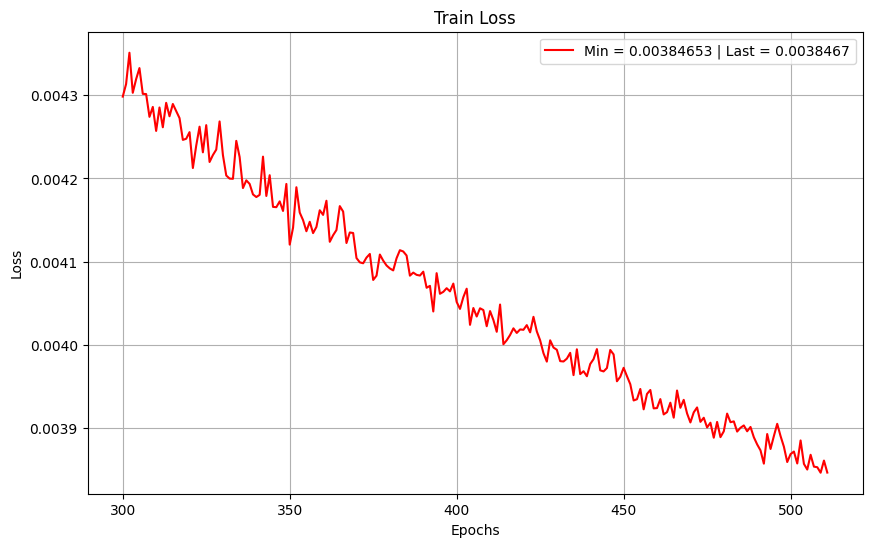

In [ ]:
memory_mask, tgt_mask, model = memory_mask.cpu(), tgt_mask.cpu(), model.cpu()
enc_x, dec_x,  tgt_y  = enc_x.cpu(), dec_x.cpu(), tgt_y.cpu()

---
### Inference Loop

All batch at once

In [ ]:
def inference_batch(model, src, forecast_window, verbose=False):
    print(src.shape)
    # Take the last value of the target variable in all batches in src and make it tgt as per the Influenza paper
    tgt = src[:, -1, :].unsqueeze(-1) # shape [batch_size, 1, 1]

    if verbose: print(f'#1) input: {src.shape} | decoder_input: {tgt.shape}')
    # if verbose: print(f'Source: {src} | Target: {tgt}')
    # Iteratively concatenate tgt with the first element in the prediction
    for i in range(forecast_window-1):
        # Create masks
        dim_a = tgt.shape[0]
        dim_b = src.shape[1]
        tgt_mask = generate_square_subsequent_mask(dim_a,dim_a,)
        src_mask = generate_square_subsequent_mask(dim_a, dim_b)
        # if verbose: print(f'#2) tgt_mask: {tgt_mask.shape} | src_mask: {src_mask.shape}')
        # Make prediction
        pred_y = model(src, tgt)
        
        if verbose: 
            print(f'#3.{i}) input: {src.shape} | decoder_input: {tgt.shape} | pred_y: {pred_y.shape}')

        # Obtain predicted value
        last_predicted_value = pred_y[:, -1, :]
        # Reshape from [batch_size, 1] --> [batch_size, 1, 1]
        last_predicted_value = last_predicted_value.unsqueeze(-1)
        # Detach the predicted element from the graph and concatenate in sequece dimention(time)
        tgt = torch.cat((tgt, last_predicted_value.detach()), 1)
    
    # Create masks
    dim_a = tgt.shape[1]
    dim_b = src.shape[1]
    tgt_mask = generate_square_subsequent_mask(dim_a, dim_a)
    src_mask = generate_square_subsequent_mask(dim_a, dim_b)

    # Make final prediction
    final_prediction = model(src, tgt, src_mask, tgt_mask)

    return final_prediction

Walk-forward inference

/tmp/ipykernel_6153/1185338192.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_y = inference_flat_serie(model, torch.tensor(data, dtype=torch.float32), FORECAST_HORIZON)


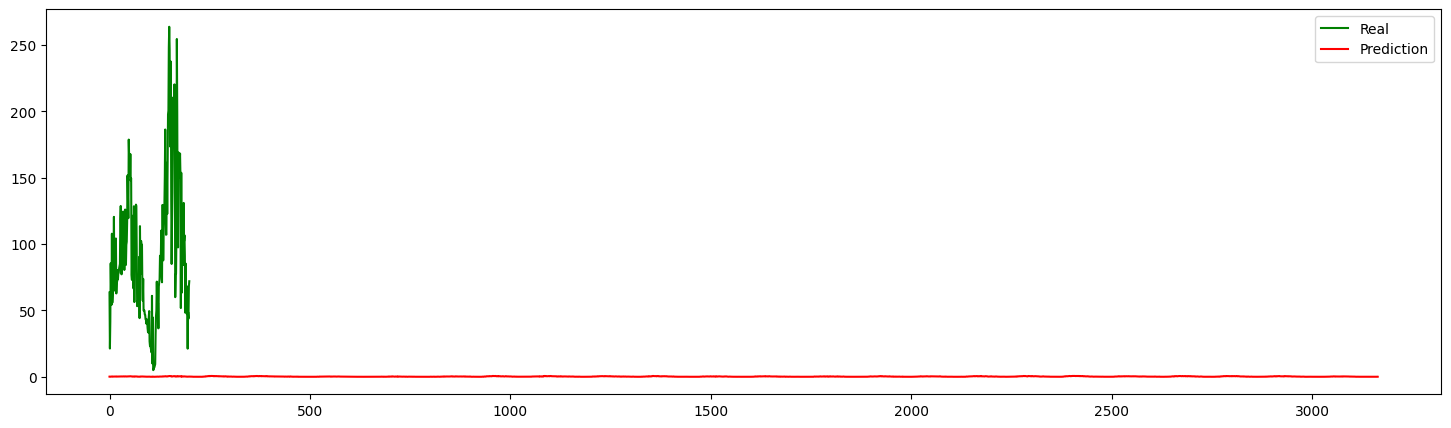

In [ ]:
def inference_flat_serie(model, serie_data, forecast_horion, verbose=False):
    input_len = model.input_len
    point_forecasts = []
    for i in range(forecast_horion):
        src = serie_data[i:i+input_len].reshape(1,-1, 1) # encoder input
        tgt = src[:, -1, :].unsqueeze(-1) # decoder input shape [batch_size, 1, 1]
        # Create masks
        dim_a = tgt.shape[0]
        dim_b = src.shape[1]
        tgt_mask = generate_square_subsequent_mask(dim_a,dim_a,)
        src_mask = generate_square_subsequent_mask(dim_a, dim_b)
        # Make prediction
        pred_y = model(src, tgt, src_mask, tgt_mask)
        
        if verbose: 
            print(f'#3.{i}) input: {src.shape} | decoder_input: {tgt.shape} | pred_y: {pred_y.shape}')

        # Obtain predicted value
        point_forecasts.append(pred_y.squeeze().detach())
        i += 1
        
    
    return np.asarray(point_forecasts) #np.concatenate([serie_data[:input_len], np.asarray(point_forecasts)])

model.eval() # sets all layers to eval
pred_y = inference_flat_serie(model, torch.tensor(data, dtype=torch.float32), FORECAST_HORIZON)
# pred_y = scaler.inverse_transform(pred_y.reshape(-1,1)).flatten()
plot_predictions(data[:200], pred_y)


Inference (kevin)

/tmp/ipykernel_6153/842770502.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


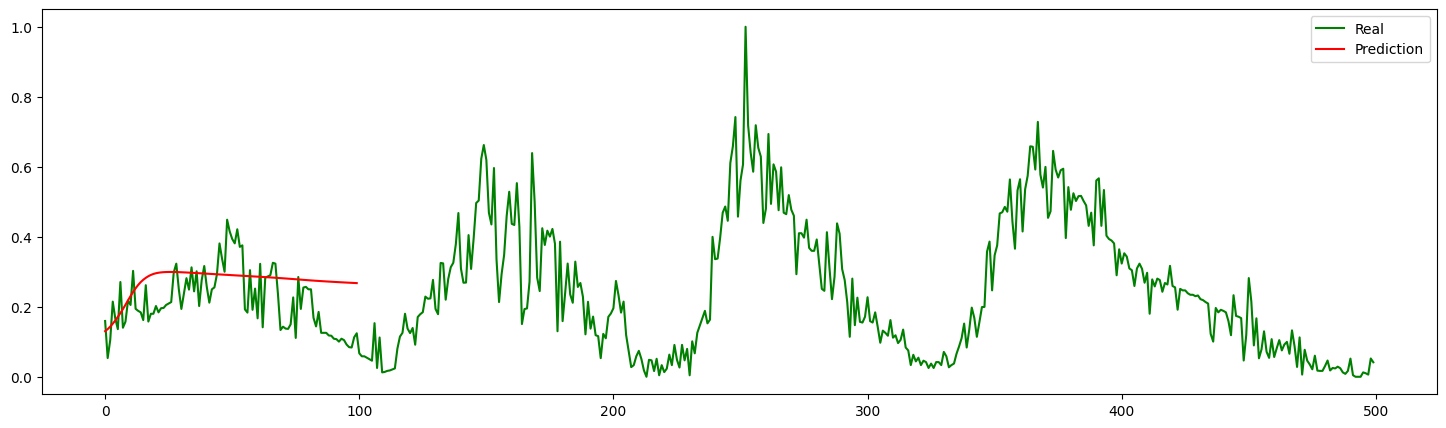

In [34]:
def pointwise_forecast(model, last_values, future_steps=2, verbose=False):
    point_forecasts = []

    for i in range(future_steps):
        with torch.no_grad():
            # last_values = last_values[-input_len:]
            src = last_values.reshape(1,-1, 1) # encoder input
            tgt = src[:, -1, :].unsqueeze(-1) # decoder input shape [batch_size, 1, 1]
            # Create masks
            dim_a = tgt.shape[0]
            dim_b = src.shape[1]
            tgt_mask = generate_square_subsequent_mask(dim_a,dim_a,)
            src_mask = generate_square_subsequent_mask(dim_a, dim_b)
            # Make prediction
            pred_y = model(src, tgt, src_mask, tgt_mask).squeeze().detach()
            
            if verbose: 
                print(f'#3.{i}) input: {src.shape} | decoder_input: {tgt.shape} | pred_y: {pred_y.shape}')

            # Obtain predicted value
            point_forecasts.append(pred_y)
            # add in the serie history
            last_values = torch.cat([last_values, pred_y.unsqueeze(0)], 0)    
        
    return np.asarray(point_forecasts) #np.concatenate([serie_data[:input_len], np.asarray(point_forecasts)])
data = torch.tensor(data, dtype=torch.float32)
first_values = data[:HISTORY]
pred_y = pointwise_forecast(model, first_values, future_steps=100)
# pred_y = scaler.inverse_transform(pred_y.reshape(-1,1)).flatten()
model.eval() # sets all layers to eval
plot_predictions(data[HISTORY:HISTORY+500], pred_y)

/tmp/ipykernel_6153/1918324298.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


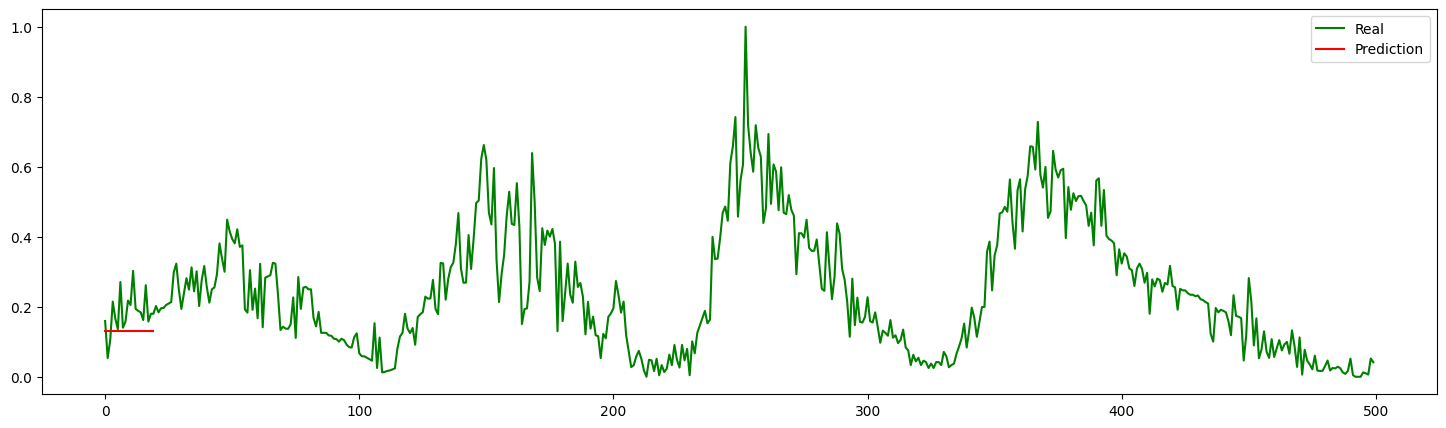

In [73]:
def pointwise_forecast(model, last_values, future_steps=2, verbose=False):
    
    point_forecasts = []

    for i in range(future_steps):
        with torch.no_grad():
            src = last_values.reshape(1,-1, 1) # encoder input
            tgt = src[:, -1, :].unsqueeze(-1) # decoder input shape [batch_size, 1, 1]
            # Create masks
            dim_a = tgt.shape[0]
            dim_b = src.shape[1]
            tgt_mask = generate_square_subsequent_mask(dim_a,dim_a)
            src_mask = generate_square_subsequent_mask(dim_a, dim_b)
            # Make prediction
            pred_y = model(src, tgt,  src_mask, tgt_mask)
            
            if verbose: 
                print(f'#3.{i}) input: {src.shape} | decoder_input: {tgt.shape} | pred_y: {pred_y.shape}')

            # Obtain predicted value
            point_forecasts.append(pred_y[:,-1,0].squeeze().detach())
            # add in the serie history
            tgt = torch.cat([tgt, pred_y[:,-1,:].unsqueeze(-1)], 1)    
        
    return np.asarray(point_forecasts) #np.concatenate([serie_data[:input_len], np.asarray(point_forecasts)])

model.eval() # sets all layers to eval
data = torch.tensor(data, dtype=torch.float32)
first_values = data[:HISTORY]
pred_y = pointwise_forecast(model, first_values, future_steps=20)
# pred_y = scaler.inverse_transform(pred_y.reshape(-1,1)).flatten()
plot_predictions(data[HISTORY:HISTORY+500], pred_y)

---
### See Predictions

In [ ]:
FORECAST_WINDOW = 10

torch.Size([1981, 10, 1])


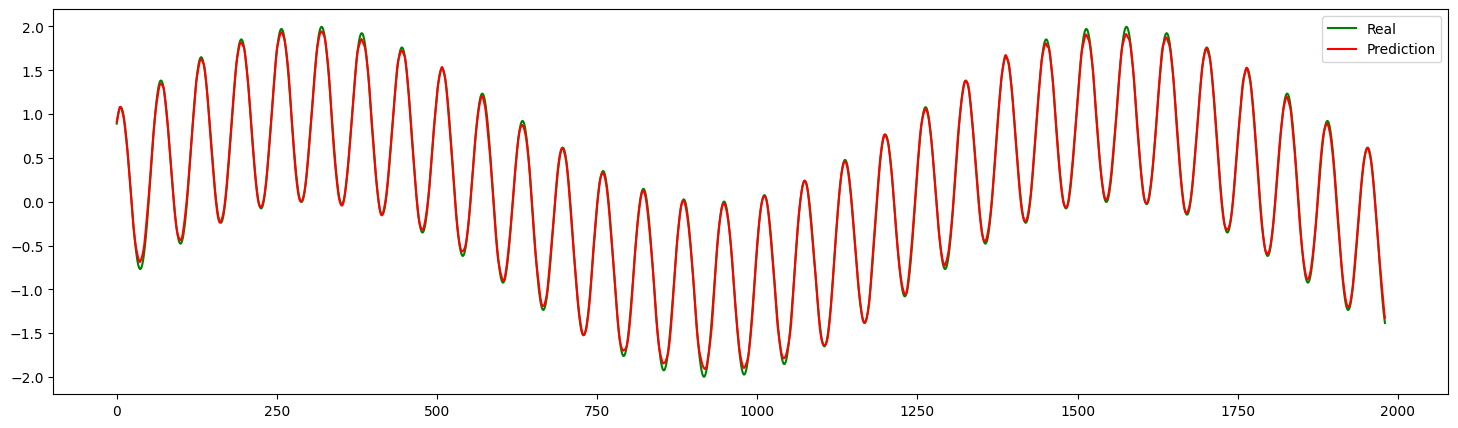

torch.Size([1981, 10, 1])


In [ ]:
pred_y = inference_batch(model, enc_x, FORECAST_WINDOW, verbose=False)
plot_predictions(tgt_y[:,0], pred_y.detach().numpy()[:,0])
print(pred_y.shape)

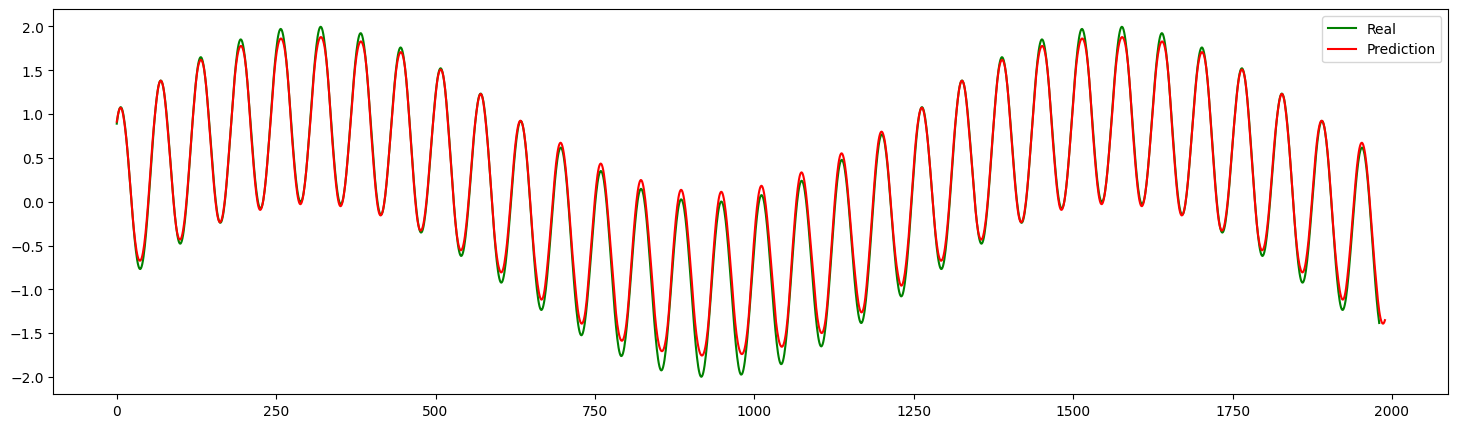

In [ ]:
pred_y = inference_flat_serie(model, data, verbose=False)
plot_predictions(tgt_y[:,0], pred_y)


In [ ]:
data2 = torch.tensor(data.numpy().copy(), dtype=torch.float32)[:12]
print('Serie:',data2)
enc_x2, dec_x2, tgt_y2 = make_batches(data2, INPUT_LEN, 1)
print('batches',enc_x2.shape)
print('Encoder input:',enc_x2.squeeze())
enc_x2[0,:,0] = 1000000 # modificar informacoes do batch anterior nao deveria modificar o output do proximo batch
print(enc_x2.shape)
FORECAST_WINDOW = 1
pred_y = inference_batch(model, enc_x2, FORECAST_WINDOW, verbose=False)
pred_y.detach().numpy()

Serie: tensor([0.0000, 0.1048, 0.2087, 0.3105, 0.4094, 0.5044, 0.5946, 0.6792, 0.7573,
        0.8283, 0.8915, 0.9462])
batches torch.Size([2, 10, 1])
Encoder input: tensor([[0.0000, 0.1048, 0.2087, 0.3105, 0.4094, 0.5044, 0.5946, 0.6792, 0.7573,
         0.8283],
        [0.1048, 0.2087, 0.3105, 0.4094, 0.5044, 0.5946, 0.6792, 0.7573, 0.8283,
         0.8915]])
torch.Size([2, 10, 1])
torch.Size([2, 10, 1])


array([[[3.2144382 ]],

       [[0.95441115]]], dtype=float32)

In [ ]:
data2 = torch.tensor(data.numpy().copy(), dtype=torch.float32)[:12]
print('Serie:',data2)
FORECAST_WINDOW = 1
pred_y = inference_flat_serie(model, data2, FORECAST_WINDOW)
pred_y

Serie: tensor([0.0000, 0.1048, 0.2087, 0.3105, 0.4094, 0.5044, 0.5946, 0.6792, 0.7573,
        0.8283, 0.8915, 0.9462])
#3.0) input: torch.Size([1, 10, 1]) | decoder_input: torch.Size([1, 1, 1]) | pred_y: torch.Size([1, 1, 1])
#3.1) input: torch.Size([1, 10, 1]) | decoder_input: torch.Size([1, 1, 1]) | pred_y: torch.Size([1, 1, 1])


array([0.9138886, 0.9592047], dtype=float32)

## Assert

In [ ]:
data2 = torch.tensor(data.numpy().copy(), dtype=torch.float32)[:13]
enc_x2, _, tgt_y2 = make_batches(data2, INPUT_LEN, 1)
print('Num of batches:', enc_x2.shape[0])
# enc_x2[2,:,:] = 1000000 # modificar informacoes do batch anterior nao deveria modificar o output do proximo batch
# enc_x2[2,:,:] = 1000000 # modificar informacoes do batch anterior nao deveria modificar o output do proximo batch

print(enc_x2.shape)
FORECAST_WINDOW = 1
pred_y = inference_batch(model, enc_x2, FORECAST_WINDOW, verbose=False)
pred_y.detach().numpy()

Num of batches: 3
torch.Size([3, 10, 1])
torch.Size([3, 10, 1])


array([[[0.73780143]],

       [[0.8286234 ]],

       [[0.91800517]]], dtype=float32)

In [ ]:
data2 = torch.tensor(data.numpy().copy(), dtype=torch.float32)[:13]
enc_x2, _, tgt_y2 = make_batches(data2, INPUT_LEN, 1)
print('Num of batches:', enc_x2.shape[0])
# enc_x2[0,:,:] = 1000000 # modificar informacoes do batch anterior nao deveria modificar o output do proximo batch
# enc_x2[2,:,:] = 1000000 # modificar informacoes do batch anterior nao deveria modificar o output do proximo batch
data2[-1] = -10000
print(enc_x2.shape)
FORECAST_WINDOW = 1
pred_y = inference_flat_serie(model, data2, verbose=False)
pred_y#.detach().numpy()


Num of batches: 3
torch.Size([3, 10, 1])


array([0.16898002, 0.24145067, 0.8578568 ], dtype=float32)

In [ ]:
epochs = 10
forecast_window = 48 # supposing you're forecasting 48 hours ahead
enc_seq_len = 168 # supposing you want the model to base its forecasts on the previous 7 days of data
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
# Iterate over all epochs
for epoch in range(epochs):
    # Iterate over all (x,y) pairs in training dataloader
    for i, (src, tgt, tgt_y) in enumerate(training_dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Generate masks
        tgt_mask = generate_square_subsequent_mask(
            dim1=forecast_window,
            dim2=forecast_window
            )

        src_mask = generate_square_subsequent_mask(
            dim1=forecast_window,
            dim2=enc_seq_len
            )
        # Make forecasts
        prediction = model(src, tgt, src_mask, tgt_mask)

        # Compute and backprop loss
        loss = criterion(tgt_y, prediction)

        loss.backward()

        # Take optimizer step
        optimizer.step()


    # Iterate over all (x,y) pairs in validation dataloader
    model.eval()